In [58]:
n = 22.29 #From paper, not sure where he got the .29
days_a_year = 365
solar_year = 365.25
trading_year = 252
print(n*days_a_year, "year")
print(n*solar_year, "solar")
print(n*trading_year, "trading") # Rule out

8135.849999999999 year
8141.4225 solar
5617.08 trading


In [59]:

from datetime import datetime, timedelta

# Define the start date
start_date = datetime(2022, 12, 31) #Date from Paper

# Define the number of days to subtract
days_to_subtract = 8034 #The number of days to Jan 1st
normal_days_to_subtract = 8135.849
Solar_days_to_subtract = 8141.4225

# Calculate the target date by subtracting the number of days
target_date = start_date - timedelta(days=days_to_subtract)
normal_target_date = start_date - timedelta(days=normal_days_to_subtract)
Solar_target_date = start_date - timedelta(days=Solar_days_to_subtract)

# Print the result
print("The date 8034 days before December 31, 2022 is:", target_date.strftime('%Y-%m-%d'))
print("The date 8135.849 days before December 31, 2022 is:", normal_target_date.strftime('%Y-%m-%d'))
print("The date 8141.4225 days before December 31, 2022 is:", Solar_target_date.strftime('%Y-%m-%d'))


The date 8034 days before December 31, 2022 is: 2001-01-01
The date 8135.849 days before December 31, 2022 is: 2000-09-21
The date 8141.4225 days before December 31, 2022 is: 2000-09-15


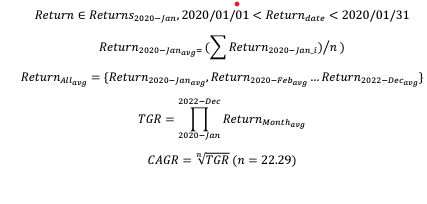

Total Growth Rate(TGR)

    *Return_month = Sum(ind. retruns in month)/ # of trades in the month
    TGR = prod(1 + Return_month)

Compound Annual Growth RAte (CAGR)

    CAGR = (TGR/100)^1/n - 1
    n = # of years or months divided by 12 in study period

Code below mimics as closely as possible 5MA CROSS 10MA and MACD, for long Positions on page 6 and 7. 


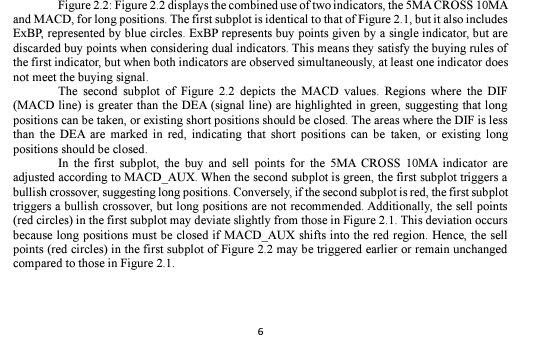


[*********************100%%**********************]  1 of 1 completed

Final Portfolio Value: $195311.53
Return: 95.31%
TGR: 2.0076
CAGR: 1.2615


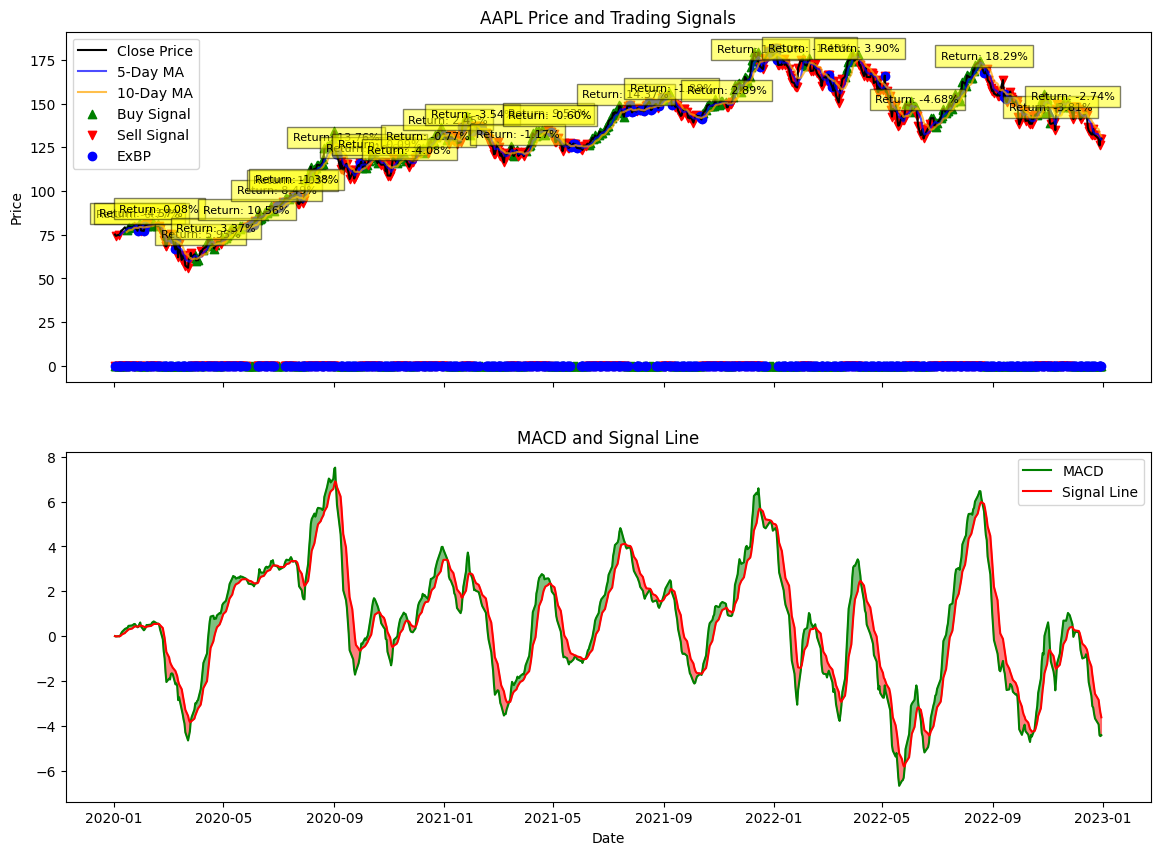

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# Fetch historical stock data
ticker = "AAPL"
data = yf.download(ticker, start="2020-01-01", end="2022-12-31")

# Calculate Moving Averages
data['5MA'] = data['Close'].rolling(window=5).mean()
data['10MA'] = data['Close'].rolling(window=10).mean()

# Calculate MACD
data['12EMA'] = data['Close'].ewm(span=12).mean()
data['26EMA'] = data['Close'].ewm(span=26).mean()
data['MACD'] = data['12EMA'] - data['26EMA']
data['Signal'] = data['MACD'].ewm(span=9).mean()

# Generate Buy/Sell signals based on 5MA and 10MA
data['Buy_Signal_1'] = np.where((data['5MA'] > data['10MA']), 1, 0)
data['Sell_Signal_1'] = np.where((data['5MA'] < data['10MA']), 1, 0)

# Adjust Buy/Sell signals based on MACD
data['Buy_Signal'] = np.where((data['Buy_Signal_1'] == 1) & (data['MACD'] > data['Signal']), 1, 0)
data['Sell_Signal'] = np.where((data['Sell_Signal_1'] == 1) | (data['MACD'] < data['Signal']), 1, 0)

# Calculate ExBP points
data['ExBP'] = np.where((data['Buy_Signal_1'] == 1) & (data['MACD'] <= data['Signal']), 1, 0)

# Initialize Portfolio
initial_cash = 100000
cash = initial_cash
position = 0
portfolio_value = []

# Backtesting
trade_returns = []
in_position = False

for i in range(len(data)):
    if data['Buy_Signal'].iloc[i] == 1 and cash > 0 and not in_position:
        position = cash // data['Close'].iloc[i]  # Buy as many shares as possible
        buy_price = data['Close'].iloc[i]
        cash -= position * buy_price
        in_position = True
    elif data['Sell_Signal'].iloc[i] == 1 and position > 0 and in_position:
        sell_price = data['Close'].iloc[i]
        cash += position * sell_price  # Sell all shares
        position = 0
        trade_return = (sell_price - buy_price) / buy_price
        trade_returns.append((i, trade_return, sell_price))
        in_position = False
    portfolio_value.append(cash + position * data['Close'].iloc[i])

data['Portfolio_Value'] = portfolio_value

# Calculate the return
final_portfolio_value = data['Portfolio_Value'].iloc[-1]
return_percentage = (final_portfolio_value - initial_cash) / initial_cash * 100

print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
print(f"Return: {return_percentage:.2f}%")

# Calculate Monthly Returns
data['Month'] = data.index.to_period('M')
monthly_returns = data.groupby('Month')['Portfolio_Value'].apply(lambda x: x.iloc[-1] / x.iloc[0] - 1)
monthly_returns = monthly_returns + 1

# Calculate TGR
TGR = monthly_returns.prod()
print(f"TGR: {TGR:.4f}")

# Calculate CAGR
n_years = len(monthly_returns) / 12
CAGR = (TGR) ** (1 / n_years)
print(f"CAGR: {CAGR:.4f}")

# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# First subplot: Price and buy/sell signals
ax1.plot(data['Close'], label='Close Price', color='black')
ax1.plot(data['5MA'], label='5-Day MA', alpha=0.7, color='blue')
ax1.plot(data['10MA'], label='10-Day MA', alpha=0.7, color='orange')
ax1.scatter(data.index, data['Buy_Signal'] * data['Close'], marker='^', color='green', label='Buy Signal', alpha=1)
ax1.scatter(data.index, data['Sell_Signal'] * data['Close'], marker='v', color='red', label='Sell Signal', alpha=1)
ax1.scatter(data.index, data['ExBP'] * data['Close'], marker='o', color='blue', label='ExBP', alpha=1)

# Add annotations for trade returns
for (i, trade_return, sell_price) in trade_returns:
    ax1.annotate(f'Return: {trade_return:.2%}',
                 (data.index[i], sell_price),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 fontsize=8,
                 bbox=dict(facecolor='yellow', alpha=0.5))

ax1.set_title(f'{ticker} Price and Trading Signals')
ax1.set_ylabel('Price')
ax1.legend()

# Second subplot: MACD and Signal Line
ax2.plot(data['MACD'], label='MACD', color='green')
ax2.plot(data['Signal'], label='Signal Line', color='red')
ax2.fill_between(data.index, data['MACD'], data['Signal'], where=(data['MACD'] >= data['Signal']), color='green', alpha=0.5)
ax2.fill_between(data.index, data['MACD'], data['Signal'], where=(data['MACD'] < data['Signal']), color='red', alpha=0.5)
ax2.set_title('MACD and Signal Line')
ax2.set_xlabel('Date')
ax2.legend()

plt.show()

From page 7.

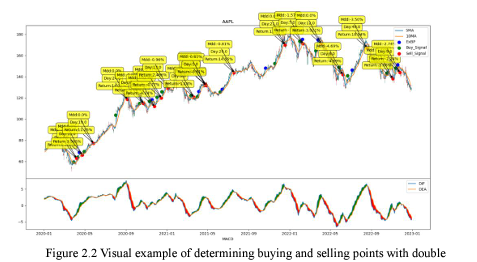

In [75]:
# Calculate Monthly Returns
data['Month'] = data.index.to_period('M')
monthly_returns = data.groupby('Month')['Portfolio_Value'].apply(lambda x: x.iloc[-1] / x.iloc[0] - 1)
#monthly_returns = monthly_returns + 1

Month
2020-01    0.946985
2020-02    1.000843
2020-03    1.026434
2020-04    1.149894
2020-05    1.100396
2020-06    1.084902
2020-07    0.996390
2020-08    1.184486
2020-09    0.900900
2020-10    0.983577
2020-11    0.959231
2020-12    1.029670
2021-01    0.960615
2021-02    1.000000
2021-03    0.988315
2021-04    1.088604
2021-05    1.000000
2021-06    1.077270
2021-07    1.059189
2021-08    1.000000
2021-09    0.976808
2021-10    1.042006
2021-11    1.069394
2021-12    1.038645
2022-01    1.000000
2022-02    0.985745
2022-03    1.055779
2022-04    0.985780
2022-05    0.994655
2022-06    0.925771
2022-07    1.169593
2022-08    1.037496
2022-09    1.000000
2022-10    1.065891
2022-11    0.893414
2022-12    1.000000
Freq: M, Name: Portfolio_Value, dtype: float64
